In [2]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow.ipc as ipc
import pyarrow.feather as feather

from utils.loading import *

## tag analysis
from wordcloud import WordCloud
from collections import Counter
import gensim.downloader as api
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
NOTEBOOK_PATH = os.getcwd()
DATA_PATH = os.path.join(NOTEBOOK_PATH, "data_youniverse")
CATEGORY = "People & Blogs"
CATEGORY_FILE_NAME = ''.join(CATEGORY.split(" ")).lower()
CATEGORY_FILE_PATH = os.path.join(DATA_PATH, f"df_channels_{CATEGORY_FILE_NAME}.tsv.gz")

# Data Loading

In [4]:
df_yt_metadata_filtered = pd.read_csv(CATEGORY_FILE_PATH, compression="infer")
df_yt_metadata_filtered['upload_date'] = pd.to_datetime(df_yt_metadata_filtered['upload_date'])
df_yt_metadata_filtered.dropna(subset=['tags'], inplace=True)

In [5]:
df_yt_metadata_filtered

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,upload_date,view_count
0,People & Blogs,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:35.725333,0.0,LZPh8ky-RP8,175,8.0,"thomas train,thomas toby,thomas salty,thomas p...",2015-11-07,1307.0
1,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.405938,613.0,BDnF-EgqAGw,398,49464.0,"vine,vines,vine compilation,chaotic good",2019-02-05,1142835.0
2,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.959894,588.0,wrTIXbQED80,375,32726.0,"vines,vine,vine compilation,neutral good,align...",2019-01-31,819654.0
3,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:31.467288,1177.0,uyWL0ZWibyU,335,86222.0,"vine,vines,vine compilation,neutral evil",2019-01-22,2159837.0
5,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:32.579907,991.0,-Ia18bqO-9w,367,75504.0,"vine,vine compilation,vines,lawful good",2019-01-09,1636316.0
...,...,...,...,...,...,...,...,...,...,...
6910661,People & Blogs,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:52:07.399834,4.0,ZoX0oaNFvxg,800,70.0,"BJP,BJP Video,Bharatiya Janata Party,BJP India...",2012-12-24,7407.0
6910662,People & Blogs,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:51:11.623882,2.0,bndveaoQPKA,81,28.0,"Bharatiya Janata Party,Join BJP,News,Politics,...",2013-09-30,4245.0
6910663,People & Blogs,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:51:09.059925,117.0,MRWCIO7oTZ8,85,975.0,"News,Teacher (Occupation),Teachers' Day (Holid...",2013-09-05,221526.0
6910664,People & Blogs,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:54:43.361733,40.0,nHWOKj1wr-I,360,1932.0,"BJP,Atal Bihari Vajpayee,Poet,Poetry,Poem,Kavi...",2010-10-04,150259.0


### Trying to filter w. YouTubers using ONLY "People and Blogs"

In [10]:
df_channels_en = pd.read_csv(os.path.join(DATA_PATH, "df_channels_en.tsv.gz"), compression="infer", sep="\t")
df_channels_people_blogs = df_channels_en[df_channels_en["category_cc"] == CATEGORY]
channels_people_blogs = df_channels_people_blogs["channel"]

In [12]:
df_yt_metadata_filtered = pd.read_csv(CATEGORY_FILE_PATH, compression="infer")
df_yt_metadata_filtered['upload_date'] = pd.to_datetime(df_yt_metadata_filtered['upload_date'])
df_yt_metadata_filtered.dropna(subset=['tags'], inplace=True)

# test to see if there's a difference
#df_yt_metadata_filtered = df_yt_metadata_filtered[df_yt_metadata_filtered["channel_id"].isin(df_channels_people_blogs)]

In [13]:
display(df_yt_metadata_filtered)


,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,upload_date,view_count
0,People & Blogs,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:35.725333,0.0,LZPh8ky-RP8,175,8.0,"thomas train,thomas toby,thomas salty,thomas p...",2015-11-07,1307.0
1,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.405938,613.0,BDnF-EgqAGw,398,49464.0,"vine,vines,vine compilation,chaotic good",2019-02-05,1142835.0
2,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.959894,588.0,wrTIXbQED80,375,32726.0,"vines,vine,vine compilation,neutral good,align...",2019-01-31,819654.0
3,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:31.467288,1177.0,uyWL0ZWibyU,335,86222.0,"vine,vines,vine compilation,neutral evil",2019-01-22,2159837.0
5,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:32.579907,991.0,-Ia18bqO-9w,367,75504.0,"vine,vine compilation,vines,lawful good",2019-01-09,1636316.0
...,...,...,...,...,...,...,...,...,...,...
6910661,People & Blogs,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:52:07.399834,4.0,ZoX0oaNFvxg,800,70.0,"BJP,BJP Video,Bharatiya Janata Party,BJP India...",2012-12-24,7407.0
6910662,People & Blogs,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:51:11.623882,2.0,bndveaoQPKA,81,28.0,"Bharatiya Janata Party,Join BJP,News,Politics,...",2013-09-30,4245.0
6910663,People & Blogs,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:51:09.059925,117.0,MRWCIO7oTZ8,85,975.0,"News,Teacher (Occupation),Teachers' Day (Holid...",2013-09-05,221526.0
6910664,People & Blogs,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:54:43.361733,40.0,nHWOKj1wr-I,360,1932.0,"BJP,Atal Bihari Vajpayee,Poet,Poetry,Poem,Kavi...",2010-10-04,150259.0


# Tag Evolution in People & Blogs Over The Years

## Number of Tags Listed Per Year

In [17]:
# make new column with number of tags for each video
df_yt_metadata_filtered['tag_count'] = df_yt_metadata_filtered['tags'].astype(str).apply(lambda x: len(x.split(',')))

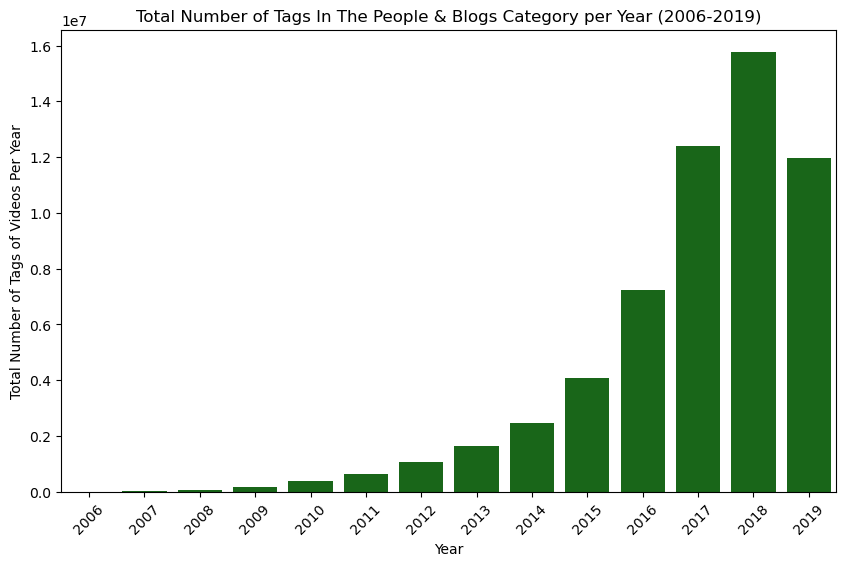

In [106]:
# calculate sum of tags per year
tag_count_per_year = df_yt_metadata_filtered.groupby(df_yt_metadata_filtered["upload_date"].dt.year)['tag_count'].sum()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=tag_count_per_year.index, y=tag_count_per_year.values, color="g", saturation=0.6)
plt.xticks(rotation=45)
plt.ylabel("Total Number of Tags of Videos Per Year")
plt.xlabel("Year")
plt.title("Total Number of Tags In The People & Blogs Category per Year (2006-2019)")
plt.show();

## Mean Number of Tags Per Year 

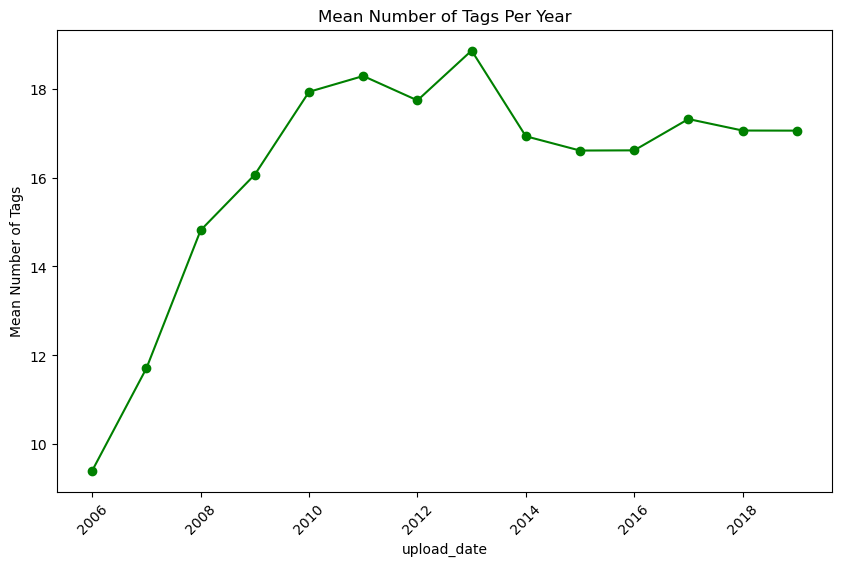

In [107]:
# Calculate the mean number of tags per year
mean_tag_count_per_year = df_yt_metadata_filtered.groupby(df_yt_metadata_filtered["upload_date"].dt.year)['tag_count'].mean()

# Create the line plot with dots
plt.figure(figsize=(10, 6))
mean_tag_count_per_year.plot(kind='line', marker='o', color="g")
plt.xticks(rotation=45)
plt.ylabel("Mean Number of Tags")
plt.title("Mean Number of Tags Per Year")
plt.show()


## Wordcloud (testing for visualization)

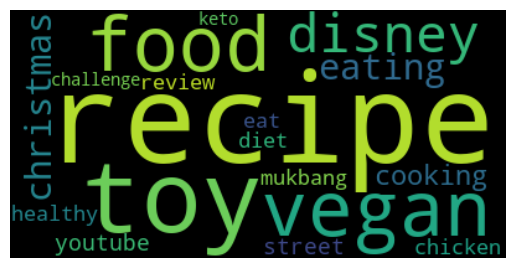

In [82]:
text = "food recipe vegan in disney eating christmas cooking to youtube recipes the street healthy chicken how toys eat diet mukbang review toy challenge keto and"

# Create a word cloud
wordcloud = WordCloud().generate(text)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sub-Categories
From the LDA analysis we defined 10 potential subcategories or themes (there could be more)


Topic #0:
food recipe vegan in disney eating christmas cooking to youtube recipes the street healthy chicken how toys eat diet mukbang review toy challenge keto and
Topic #1:
of the god jesus christian bible is and healing church life religion to tv christ you love prayer beer spirit holy people islam truth spiritual
Topic #2:
tarot love reading astrology horoscope 2018 2019 reaction gay weekly the 2017 psychic kpop de cancer in leo football aries taurus virgo scorpio gemini libra
Topic #3:
news live stock hair tv latest today analysis market cnbc technical awaaz india trump abp somoy in bangladesh hindi bangla local election 2018 comedy top
Topic #4:
vlog family vlogs the life baby daily kids in vlogger and funny mom day fun travel vloggers video new my vlogging cute couple of with
Topic #5:
to how for in tips make weight fitness workout home money health diy get business loss tutorial and of training your free online best school
Topic #6:
video the game movie of new reaction funny best comedy vs film games tv world in top wwe and dj song van trailer full gaming
Topic #7:
art review car fishing book rv the to bike books living house truck in how painting and best water cars cleaning fish camping with trailer
Topic #8:
asmr birthday happy music song songs musical bitcoin to video 2018 sounds beat planner dance with yoga best ali sleep for khan massage you type
Topic #9:
haul makeup movies fashion beauty review new 2017 the 2018 latest tutorial yoruba on vape and lego dollar nigerian 2016 for celebrity shopping style best

From the list of words in each topic, we can infer potential subcategories or themes. A possible interpretation of each topic could be:

- Topic #0: Cooking and Food (with a focus on vegan recipes, Christmas, and potentially food-related challenges or reviews on YouTube)
- Topic #1: Religion and Spirituality (words like Jesus, Christian, Bible, church, prayer, spirit)
- Topic #2: Astrology and Horoscopes (terms related to astrology signs and psychic readings)
- Topic #3: News and Financial Analysis (with references to live TV, stock analysis, and various news outlets)
- Topic #4: Family and Daily Vlogging (keywords indicate content about family life and daily activities)
- Topic #5: Health and Fitness (including weight loss, fitness tips, and DIY health topics)
- Topic #6: Entertainment and Gaming (focusing on reaction videos, movies, games, and comedy)
- Topic #7: Outdoor and Lifestyle (with references to fishing, cars, books, and RV travel)
- Topic #8: Music and Personal Care (including ASMR, birthdays, and various music-related terms)
- Topic #9: Fashion and Beauty (with words indicating makeup, fashion, beauty tutorials, and reviews)

Each topic aggregates words that frequently co-occur in the dataset, suggesting they share a common theme or subject matter. These subcategories can be useful for understanding the main interests or content types within the text data analyzed.

## Naive Approach: Simple Tag Matching

Assign subcategory based on pre-defined tags category from the topics defined above. 

In [109]:
food_cooking_tags = ['food', 'recipe', 'vegan', 'disney eating', 'christmas cooking', 'recipes', 'street food', 'healthy', 'chicken', 'how-to cook', 'eat', 'diet', 'mukbang', 'keto']
religion_spirituality_tags = ['god', 'jesus', 'christian', 'bible', 'healing', 'church', 'religion', 'christ', 'prayer', 'spirit', 'holy', 'islam', 'spiritual']
astrology_horoscope_tags = ['tarot', 'astrology', 'horoscope', 'psychic', 'kpop astrology', 'cancer', 'leo', 'aries', 'taurus', 'virgo', 'scorpio', 'gemini', 'libra']
news_current_events_tags = ['news', 'stock market', 'cnbc', 'technical analysis', 'awaaz', 'india news', 'trump', 'abp news', 'somoy', 'bangladesh news', 'hindi news', 'bangla news', 'election news']
family_vlogging_tags = ['vlog', 'family', 'vlogs', 'baby', 'kids', 'vlogger', 'mom', 'travel vlog', 'vloggers', 'family video', 'vlogging', 'couple vlog']
lifestyle_diy_tags = ['how-to', 'diy', 'make', 'weight loss', 'fitness', 'workout', 'home improvement', 'money saving', 'health tips', 'business advice', 'tutorial', 'training', 'online learning', 'school advice']
entertainment_gaming_tags = ['video games', 'movie review', 'reaction video', 'comedy', 'film analysis', 'tv shows', 'wwe', 'dj music', 'song reaction', 'movie trailer', 'gaming']
art_outdoor_activities_tags = ['art', 'car review', 'fishing', 'book review', 'rv lifestyle', 'bike', 'painting', 'watercolor', 'car maintenance', 'fish keeping', 'camping', 'trailer life']
music_wellbeing_tags = ['asmr', 'birthday celebration', 'music', 'song cover', 'musical instrument', 'bitcoin', 'dance music', 'yoga', 'sleep music', 'massage therapy']
fashion_beauty_tags = ['fashion haul', 'makeup tutorial', 'fashion review', 'beauty tips', 'latest fashion', 'yoruba movies', 'vape review', 'lego builds', 'nigerian fashion', 'celebrity style', 'shopping guide']

# Example of how to use these lists with a lambda function
# Assuming df is your DataFrame and 'tags' is the column with the video tags
subcategories = {
    'Food & Cooking': food_cooking_tags,
    'Religion & Spirituality': religion_spirituality_tags,
    'Astrology & Horoscope': astrology_horoscope_tags,
    'News & Current Events': news_current_events_tags,
    'Family Vlogging': family_vlogging_tags,
    'Lifestyle & DIY': lifestyle_diy_tags,
    'Entertainment & Gaming': entertainment_gaming_tags,
    'Art & Outdoor Activities': art_outdoor_activities_tags,
    'Music & Wellbeing': music_wellbeing_tags,
    'Fashion & Beauty': fashion_beauty_tags
}

In [ ]:
def find_dominant_subcategory(comma_separated_tags):
    video_tags = comma_separated_tags.split(',')
    video_tags = [tag.strip().lower() for tag in video_tags]  # Stripping whitespace and converting to lower case for consistency

    tag_count = {subcategory: 0 for subcategory in subcategories.keys()}
    
    for tag in video_tags:
        for subcategory, tags in subcategories.items():
            if tag in tags:
                tag_count[subcategory] += 1

    dominant_subcategory = max(tag_count, key=tag_count.get)
    return dominant_subcategory if tag_count[dominant_subcategory] > 0 else 'Other'

# Apply the function to the DataFrame
df_yt_metadata_filtered['Subcategory'] = df_yt_metadata_filtered['tags'].apply(find_dominant_subcategory)



<Axes: title={'center': 'Number of Videos per Subcategory'}, xlabel='Subcategory'>

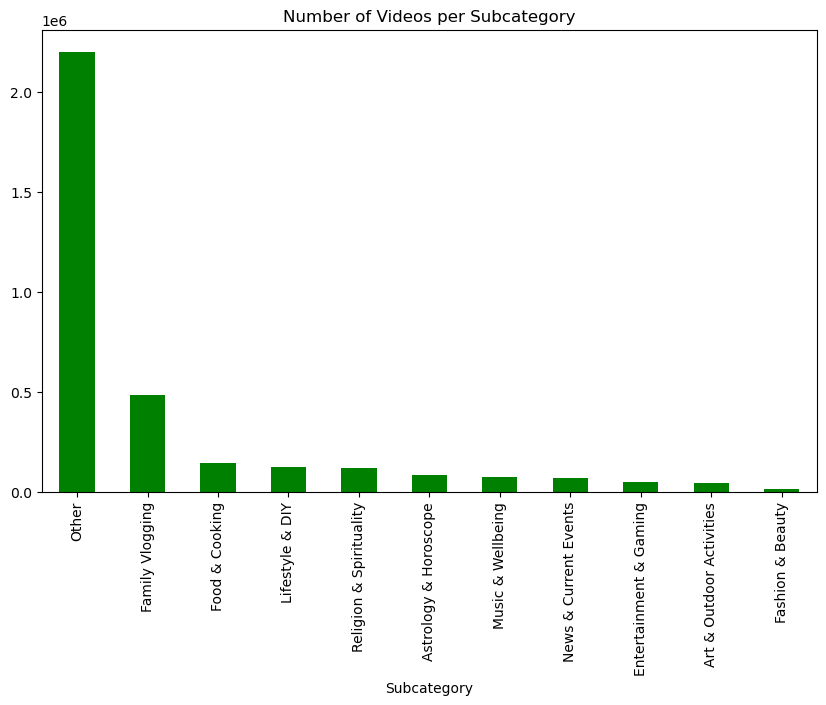

In [111]:
df_yt_metadata_filtered['Subcategory'].value_counts().plot(kind='bar', figsize=(10, 6), color='g', title='Number of Videos per Subcategory')

In [112]:
df_yt_metadata_filtered['Subcategory'].value_counts()

Subcategory
Other                       2202933
Family Vlogging              483393
Food & Cooking               141475
Lifestyle & DIY              121829
Religion & Spirituality      119201
Astrology & Horoscope         81200
Music & Wellbeing             72414
News & Current Events         65810
Entertainment & Gaming        47938
Art & Outdoor Activities      42822
Fashion & Beauty              13296
Name: count, dtype: int64

# LDA

In [21]:
## tag analysis
import pyLDAvis
import pyLDAvis.lda_model
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer


In [51]:
# Remove stopwords
stop_words = set(stopwords.words('english'))

people_blogs_tags = df_yt_metadata_filtered["tags"]
people_blogs_tags = people_blogs_tags.dropna().apply(lambda x: [tag for tag in x.split(',') if tag.lower() not in stop_words])

# Lemmatize and remove plurals and other forms of the same word
lemmatizer = nltk.stem.WordNetLemmatizer()
people_blogs_tags = people_blogs_tags.apply(lambda x: [lemmatizer.lemmatize(tag) for tag in x])

# Remove duplicates
people_blogs_tags = people_blogs_tags.apply(lambda x: list(set(x)))



In [78]:
import re

# Define the pattern to match the years 2006 to 2019
pattern = r'\b(20[06-9]|201[0-9])\b'

# Remove the years from the tags
people_blogs_tags = people_blogs_tags.apply(lambda x: [re.sub(pattern, '', tag) for tag in x])

In [ ]:
# Remove verbs
def remove_verbs(tags):
    tagged_tags = pos_tag(tags)
    filtered_tags = [tag for tag, pos in tagged_tags if pos != 'VB']
    return filtered_tags

people_blogs_tags = people_blogs_tags.dropna().apply(lambda x: [tag for tag in x.split(',') if tag.lower() not in stop_words])


In [83]:
LDA_test = people_blogs_tags.sample(100000, random_state=42) #500000

vectorizer = CountVectorizer()
tag_matrix = vectorizer.fit_transform([', '.join(tags) for tags in LDA_test])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=25, random_state=0)  # Assuming 25 subcategories

lda.fit(tag_matrix)

LatentDirichletAllocation(n_components=25, random_state=0)

In [81]:
# Each topic (subcategory) in LDA is a mixture of tags
# To get the top tags for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print_top_words(lda, vectorizer.get_feature_names_out(), 20)

Topic #0:
to birthday happy how song video funny the for you videos on in diy with lol surprise best status and
Topic #1:
fishing vegan raw kids and led lunch bass easter food the card in ideas diet aquarium plant ellie jared diving
Topic #2:
chicken football fashion air tv review on genre gopro aqua musical action water comic marvel to cbn hangouts new hoa
Topic #3:
house trailer camping gender rv tiny knife to bean survival and supplies duty towing diy cartoon reveal vehicle black funny
Topic #4:
health and beat android type of election dating benefits in samsung prank phone free tips lesbian advice cureyen the kenya
Topic #5:
tarot reading horoscope astrology love book leo psychic capricorn weekly libra pisces scorpio july taurus sagittarius aries cancer sign the
Topic #6:
in haul life the day me mom with vlog to shopping of dollar my tree what routine home yoga cleaning
Topic #7:
reaction slime muscle yoruba kpop fitness out workout the new gain song of body building and video drag

### LDA - Intertopic Distance Mapping with 25 "subcategories" | topics 

In [82]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, tag_matrix, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -2.337073  2.345366       1        1  9.529602
11    -2.326630  2.344249       2        1  8.133672
0     -2.330817  2.366038       3        1  6.731830
6     -2.324670  2.361194       4        1  5.642530
12    -2.330777  2.376417       5        1  4.867880
21    -2.245447  2.399196       6        1  4.506562
5     -2.265987  2.338902       7        1  4.316562
16    -2.260519  2.391498       8        1  4.101194
10    -2.289555  2.415768       9        1  3.981326
23    -2.327443  2.410808      10        1  3.863387
15    -2.319007  2.418943      11        1  3.432979
7     -2.327949  2.421549      12        1  3.377888
2     -2.299045  2.430216      13        1  3.295913
24    -2.244238  2.407535      14        1  3.161946
14    -2.315626  2.399045      15        1  3.048930
17    -2.312132  2.415400      16        1  3.017481
20    -2.315568  2.411255      17        1  3.016671
13    -2.302022  2.401843      18        1  2.942320
3     -2.311249  2.417927      19        1  2.829736
22    -2.308132  2.418912      20        1  2.820533
1     -2.324421  2.398490      21        1  2.778639
19    -2.324569  2.406621      22        1  2.717545
9     -2.290994  2.414927      23        1  2.701086
18    -2.316566  2.423524      24        1  2.637195
4     -2.282543  2.407317      25        1  2.546592, topic_info=         Term         Freq        Total Category  logprob  loglift
24531    news  1308.000000  1308.000000  Default  30.0000  30.0000
12210  family  1409.000000  1409.000000  Default  29.0000  29.0000
37731    vlog  1656.000000  1656.000000  Default  28.0000  28.0000
16308     how  1711.000000  1711.000000  Default  27.0000  27.0000
35676      to  2579.000000  2579.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
16894      in    37.058205  1674.441600  Topic25  -5.3187  -0.1403
20972    love    28.293161   566.391581  Topic25  -5.5885   0.6737
35124     the    29.897718  2118.600459  Topic25  -5.5334  -0.5903
13107     for    26.328256  1080.195947  Topic25  -5.6605  -0.0438
24531    news    22.508473  1308.626581  Topic25  -5.8173  -0.3924

[1653 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
109       24  0.948753             130
137       23  0.927325          150522
236        3  0.973365  1happybirthday
373       18  0.979395            2b2t
384        6  0.902072            2k19
...      ...       ...             ...
40510      6  0.902072             खबर
40595     12  0.954787              मत
40890     19  0.843725         რუსთავი
40892     19  0.843725      საქართველო
40974     18  0.844472             ケイト

[6079 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 12, 1, 7, 13, 22, 6, 17, 11, 24, 16, 8, 3, 25, 15, 18, 21, 14, 4, 23, 2, 20, 10, 19, 5])

### LDA - Intertopic Distance Mapping with 50 "subcategories" | topics 

In [43]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, tag_matrix, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -1.043941  2.424717       1        1  8.703312
31    -1.618535  3.601146       2        1  4.928015
21    -0.240512  1.079240       3        1  3.253545
40    -1.152655  3.865924       4        1  3.094118
49    -0.217646  1.025403       5        1  2.838620
35    -0.889341  2.289979       6        1  2.797677
7     -1.621726  3.020059       7        1  2.781651
44    -1.534875  4.646139       8        1  2.683596
23    -0.516606  4.486513       9        1  2.317291
22    -2.076061  3.717076      10        1  2.217552
39     0.883297  3.965303      11        1  2.205810
14     0.744540  1.644329      12        1  2.102696
33    -1.061710  2.787356      13        1  2.015317
6     -1.019734  2.496772      14        1  1.973243
10    -0.003081  2.855592      15        1  1.923109
12    -0.130091  2.627927      16        1  1.901898
3      0.487221  4.552116      17        1  1.835203
36     0.340999  1.190168      18        1  1.816768
28     0.583029  3.362179      19        1  1.800296
38    -0.464159  4.837912      20        1  1.798552
42     0.892633  1.618602      21        1  1.791123
1     -0.863653  2.378509      22        1  1.758323
11    -0.946955  2.427158      23        1  1.751929
46     0.044856  4.231729      24        1  1.744455
16    -1.591130  3.286793      25        1  1.730770
48     0.106324  2.876646      26        1  1.722103
37     0.719581  2.485178      27        1  1.692660
47     1.194155  3.656138      28        1  1.677618
24    -0.280453  3.632688      29        1  1.648325
19     0.700988  3.168634      30        1  1.643652
26     0.050105  3.411101      31        1  1.626167
18    -0.265686  4.490658      32        1  1.559950
0     -0.220430  2.833394      33        1  1.515471
5     -0.438245  4.040281      34        1  1.509607
4      0.827790  4.566272      35        1  1.506753
29     0.297898  2.525107      36        1  1.495683
27    -1.682883  1.595259      37        1  1.490246
45     0.726914  2.694185      38        1  1.489498
17     1.290461  2.939335      39        1  1.481778
9     -0.238229  3.582261      40        1  1.470346
25    -0.947992  2.028043      41        1  1.453541
8      0.453476  3.492304      42        1  1.415971
32     0.362109  2.926946      43        1  1.403119
34     0.182802  3.489704      44        1  1.308175
2     -0.223740  2.346267      45        1  1.285159
30    -0.551353  3.334622      46        1  1.253915
20    -0.867023  3.291940      47        1  1.220744
43     0.401515  4.090759      48        1  1.175011
13    -0.492362  3.796024      49        1  1.164569
41     0.056172  3.641939      50        1  1.025069, topic_info=         Term          Freq         Total Category  logprob  loglift
83903      to  14931.000000  14931.000000  Default  30.0000  30.0000
38254     how   9842.000000   9842.000000  Default  29.0000  29.0000
28572  family   9509.000000   9509.000000  Default  28.0000  28.0000
30534    food   5830.000000   5830.000000  Default  27.0000  27.0000
88781    vlog  11543.000000  11543.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
73497  secret     70.141657    443.088012  Topic50  -5.4581   2.7372
82446    test     74.037165    917.056353  Topic50  -5.4041   2.0638
77575   space     55.448099    356.155690  Topic50  -5.6932   2.7205
58089    news     60.692210   2903.911446  Topic50  -5.6029   0.7124
59738      of     61.792530   7578.278459  Topic50  -5.5849  -0.2288

[3310 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
62         1  0.005380       10
62         2  0.064559       10
62         3  0.094687       10
62         4  0.011836       10
62         5  0.002152       10
...      ...       ...      ...
97178     40  0.933334      දවස
97186     40  0.972470       වත
97230      6  0